In [33]:
import os, sys
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm

%matplotlib inline

In [5]:
sys.path.append('..')

from src.costs import l2_squared_cost
from src.mlp import MLPQuadratic
from src.metrics import unexplained_variance, sinkhorn_distance

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0x000000); np.random.seed(0x000000)

# Benchmark setup

In [ ]:
!git clone https://github.com/iamalexkorotin/Wasserstein2Benchmark.git

In [ ]:
import Wasserstein2Benchmark.src.map_benchmark as mbm
%cd ./Wasserstein2Benchmark/src

In [11]:
class BaselineModel(nn.Module):
    def __init__(self, mean):
        super().__init__()
        self.mean = torch.from_numpy(mean).to(device)

    def forward(self, X):
        n = len(X)
        return self.mean.repeat((n, 1))

In [12]:
base_path = os.path.join('../../../', 'experiments_data', 'wasserstein2')

with open(os.path.join(base_path, 'params.yaml')) as params_file:
    setup = yaml.safe_load(params_file)
    hidden_sizes = setup['hidden_sizes']

In [25]:
def load_models(dim, benchmark):
    baseline_model = BaselineModel(benchmark.output_sampler.mean)
    baseline_model.eval()
    checkpoints_path = os.path.join('../../../', 'checkpoints', 'wasserstein2')

    id_model = MLPQuadratic(dim, hidden_sizes[f'dim{dim}'])
    id_model.load_state_dict(torch.load(os.path.join(checkpoints_path, f'd{dim}_id.pt')))
    id_model.eval()

    gauss_model = MLPQuadratic(dim, hidden_sizes[f'dim{dim}'])
    gauss_model.load_state_dict(torch.load(os.path.join(checkpoints_path, f'd{dim}_gauss.pt')))
    gauss_model.eval()

    return baseline_model.to(device), id_model.to(device), gauss_model.to(device)

# Evaluate metrics

In [30]:
baseline_metrics = {
    'uvp': [],
    'div': []
}

id_metrics = {
    'uvp': [],
    'div': []
}

gauss_metrics = {
    'uvp': [],
    'div': []
}

In [31]:
dims = [2, 4, 8, 16, 32, 64, 128, 256]
eval_batch_size = 8192

for dim in tqdm(dims):
    benchmark = mbm.Mix3ToMix10Benchmark(dim)
    baseline_model, id_model, gauss_model = load_models(dim, benchmark)
    
    X = benchmark.input_sampler.sample(eval_batch_size)
    Y = benchmark.output_sampler.sample(eval_batch_size)

    with torch.no_grad():
        T_X_baseline = baseline_model(X)
        T_X_id = id_model(X)
        T_X_gauss = gauss_model(X)

    baseline_metrics['uvp'].append(unexplained_variance(benchmark, baseline_model, eval_batch_size))
    id_metrics['uvp'].append(unexplained_variance(benchmark, id_model, eval_batch_size))
    gauss_metrics['uvp'].append(unexplained_variance(benchmark, gauss_model, eval_batch_size))

    baseline_metrics['div'].append(sinkhorn_distance(Y, T_X_baseline, l2_squared_cost))
    id_metrics['div'].append(sinkhorn_distance(Y, T_X_id, l2_squared_cost))
    gauss_metrics['div'].append(sinkhorn_distance(Y, T_X_gauss, l2_squared_cost))

100%|██████████| 8/8 [03:34<00:00, 26.81s/it]


# Plot metrics

Text(0, 0.5, 'Sinkhorn Divergence: $S_{\\ell_2^2, \\epsilon}(\\mu, \\hat{T}\\sharp \\mu)$')

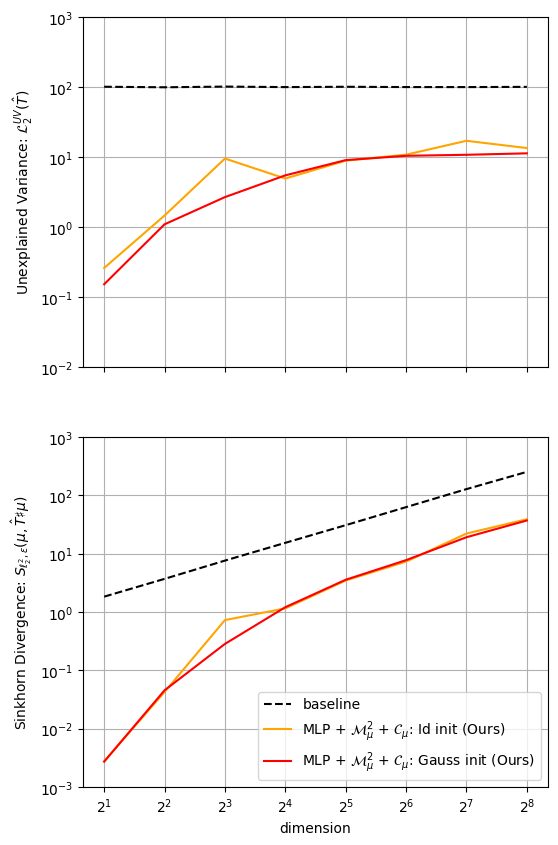

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

xticks = range(1, len(baseline_metrics['uvp']) + 1)
axes[0].plot(xticks, baseline_metrics['uvp'], linestyle='--', c='black', label='baseline')
axes[0].plot(xticks, id_metrics['uvp'], c='orange')
axes[0].plot(xticks, gauss_metrics['uvp'], c='red')

axes[0].set_yscale('symlog', linthresh=1e-3)
axes[0].set_ylim(1e-2, 1e3)
axes[0].grid()
axes[0].set_ylabel(r'Unexplained Variance: $\mathcal{L}_2^{UV}(\hat{T})$')

axes[1].plot(xticks, baseline_metrics['div'], linestyle='--', c='black', label='baseline')
axes[1].plot(xticks, id_metrics['div'], c='orange', label='MLP + $\mathcal{M}_{\mu}^2$ + $\mathcal{C}_{\mu}$: Id init (Ours)')
axes[1].plot(xticks, gauss_metrics['div'], c='red', label='MLP + $\mathcal{M}_{\mu}^2$ + $\mathcal{C}_{\mu}$: Gauss init (Ours)')

axes[1].set_xticks(xticks, [r'$2^%i$' % i for i in xticks])
axes[1].set_yscale('symlog', linthresh=1e-3)
axes[1].set_ylim(1e-3, 1e3)
axes[1].grid()

axes[1].legend(loc='lower right')
axes[1].set_xlabel('dimension')
axes[1].set_ylabel(r'Sinkhorn Divergence: $S_{\ell_2^2, \epsilon}(\mu, \hat{T}\sharp \mu)$')